# I. Introduction
## 4 -  Thermal data pre-processing

In this notebook we will apply some pre-processing steps to the data.

In [1]:
import numpy as np
import pandas as pd
#import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('talk')

In [2]:
import sys, os
sys.path.append(os.path.abspath("../code/"))

Let's read in the temperature data.

In [3]:
from thermals import get_temperature_data_from_suffix, pre_process_temperature_data

In [4]:
%%time
df = get_temperature_data_from_suffix('TelescopeTemperaturePED')

CPU times: user 11 s, sys: 3.7 s, total: 14.7 s
Wall time: 4.03 s


In [5]:
df.shape

(1100599, 13)

Wow!  It's 14 columns with 1.1 million records.

Let's do some **pre-processing** of the signals:  
1. Convert to Kelvin, in preparation for possible transformations of temperature (e.g. $\log{T}$).
2. Add Gaussian jitter to avoid problems from undersampled discretization noise.
3. Switch to DateTimeIndex indexing, in preparation for time-based matching.

In [6]:
processed_df = pre_process_temperature_data(df, add_jitter='TelescopeTemperaturePED')

In [7]:
processed_df.tail(3)

,MJD,LC,SC,PEDCRRT1,PEDCRRT2,PEDCRRT3,PEDCRRT4,PEDPMAT1,PEDPMAT2,PEDPMAT3,PEDPMAT4,PEDTELMNTT1,campaign
2018-09-26 00:47:45.888,58387.03317,168624,5047204,210.616489,212.035066,220.261379,219.709932,261.696033,261.258899,263.151962,263.513554,280.673600,19
2018-09-26 00:49:45.984,58387.03456,168624,5047206,210.602348,212.024277,220.251274,219.696331,261.622705,261.180742,263.128476,263.458331,280.743608,19
2018-09-26 00:51:45.216,58387.03594,168624,5047208,210.630022,212.029430,220.275980,219.761663,261.662028,261.212250,263.197845,263.572799,280.674016,19


I experimentally determined that the smallest changes in temperature that could be recorded were $\Delta T = 0.011 \; ^\circ C$ for the `BoardTemperatures`, but the uncertainty was somewhat less than this value, resulting in discrete jumps in temperature.  These discrete jumps foil some algorithms such as least squares.  Let's add some modest noise now, and if we have to, we can go back and remove the noise later.  Each file type has a different discretization error, but the columns within the file type appear to share the same discretization error.

In [8]:
col = 'PEDPMAT1'

In [9]:
vec1, vec2 = df[col].iloc[0:100].values, processed_df[col].iloc[0:100].values

diff_matrix1 = vec1 - vec1[:, None]
diff_matrix2 = vec2 - vec2[:, None]

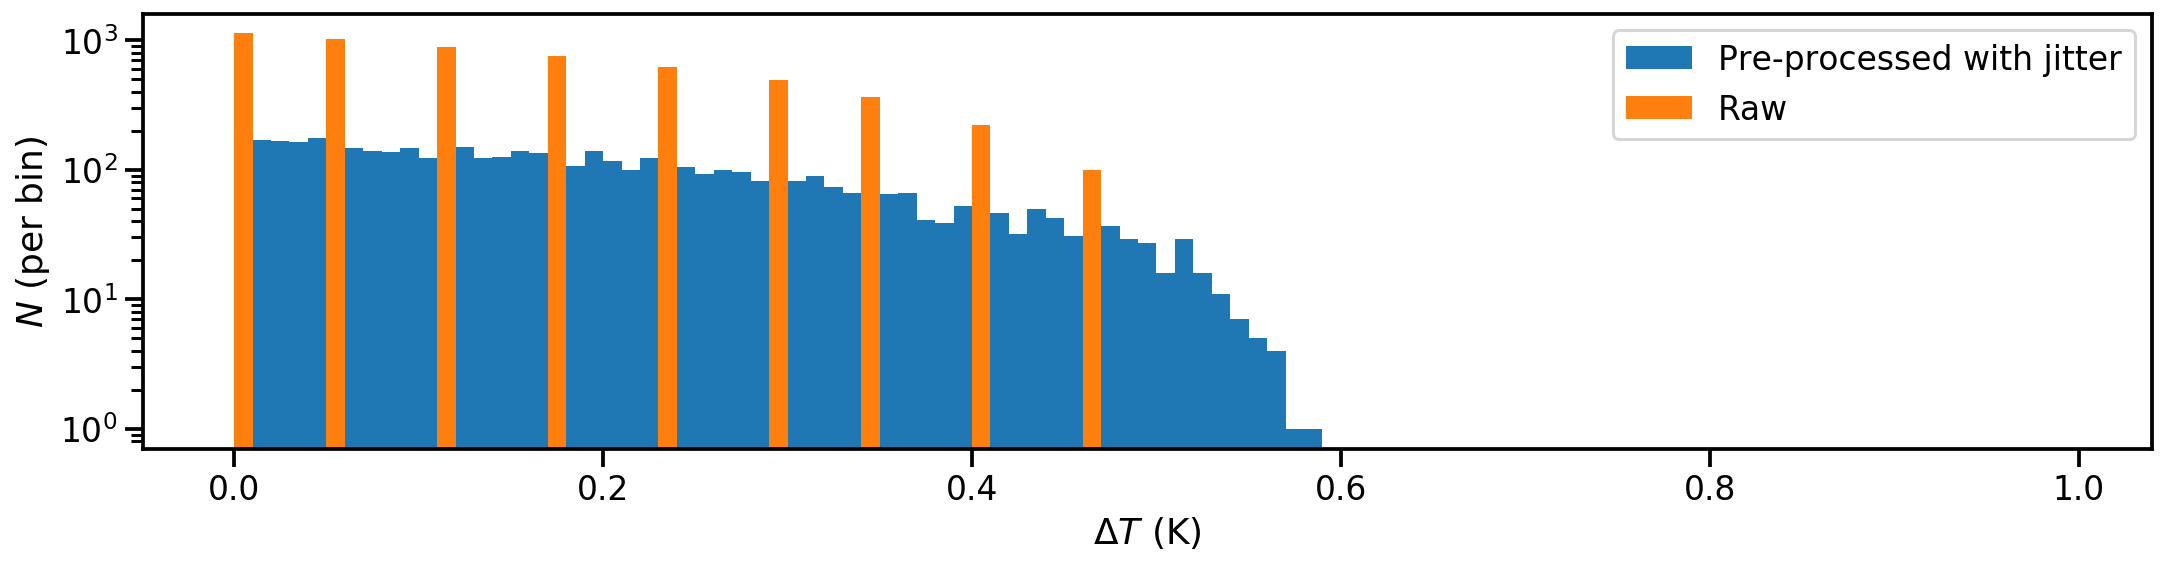

In [10]:
plt.figure(figsize=(18, 4))

plt.hist(diff_matrix2.reshape(-1), bins=np.arange(0, 1, 0.01), label='Pre-processed with jitter')
plt.hist(diff_matrix1.reshape(-1), bins=np.arange(0, 1, 0.01), label='Raw')
plt.xlabel('$\Delta T$ (K)')
plt.ylabel('$N$ (per bin)')
plt.yscale('log')
plt.legend(loc='best');

The raw data has discrete jumps in temperature that could foil algorithms expecting Gaussian white noise.  The pre-processed data is smooth.

By manually inspecting each file I find the following discretization error for each file type:

In [11]:
jitter_dict = {'BoardTemperatures':0.011, 'TelescopeTemperatureTH_2':1.0, 'TelescopeTemperaturePED':0.05, 'TelescopeTemperatureTH_1':0.35}

This jitter dictionary is included in the `pre_process_temperature_data` function as an automatic lookup table.